In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy.orm import Session, declarative_base

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()


In [6]:
# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date.date

'2017-08-23'

#### Design a query to retrieve the last 12 months of precipitation data and plot the results. 
#### Starting from the most recent data point in the database. 

In [11]:
# Calculate the date one year from the last date in data set.
year = dt.datetime.strptime(last_date.date, '%Y-%m-%d')
minus_one_year = year - dt.timedelta(days = 365)
year

datetime.datetime(2017, 8, 23, 0, 0)

In [12]:
# Perform a query to retrieve the data and precipitation scores
precip = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date.between(\
    func.strftime('%Y-%m-%d', minus_one_year),
    func.strftime('%Y-%m-%d', year))).all()

In [13]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip, columns= ['Date', 'Precipitation'])
precip_df.set_index('Date', inplace=True)

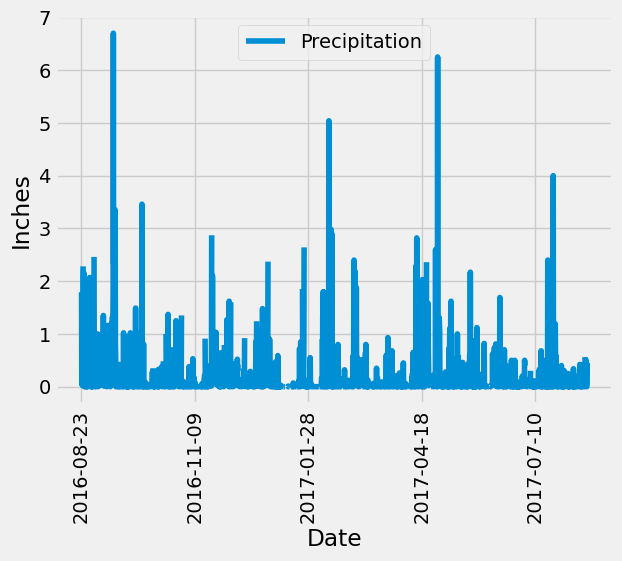

In [14]:
# Sort the dataframe by date
precip_df = precip_df.sort_index()
# Use Pandas Plotting with Matplotlib to plot the data
precip_plot = precip_df.plot(ylabel = 'Inches', rot = 90)

plt.savefig("../Resources/precip_plot.png")


In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number of stations in the dataset
# session.query(Station.station).count()
session.query(func.count(Station.station)).all()

[(9,)]

In [17]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [18]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [19]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [20]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
act_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by((func.count(Measurement.station).desc())).all()
act_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_act_station = session.query(Measurement.station, 
                    func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                    filter(Measurement.station == "USC00519281").all()
most_act_station

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

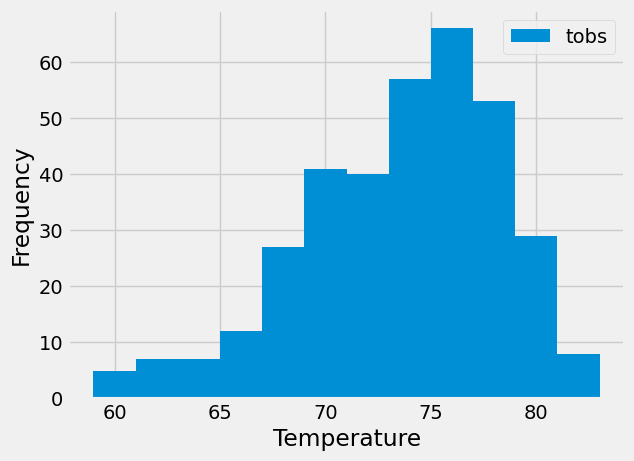

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_st_yr = [row.tobs for row in session.query(Measurement.tobs).\
    filter(Measurement.station == "USC00519281", Measurement.date.between(\
    func.strftime('%Y-%m-%d', minus_one_year),
    func.strftime('%Y-%m-%d', year))).all()]

plt.hist(most_active_st_yr, bins = 12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
label = ["tobs"]
plt.legend(label)
plt.savefig("../Resources/most_active_st_year_hist.png")

# Close Session

In [23]:
# Close Session
session.close()